In [30]:
# Importações
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [31]:
# Parâmetros
symbol = 'DIS'
start_date = '2018-01-01'
end_date = '2024-05-01'
lookback = 30

In [32]:
# Coleta dos Dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [33]:
# Feature Engineering (Delta)
df['Delta'] = df['Close'].diff().fillna(0)

In [34]:
# Seleção de Features
features = df[['Close', 'Delta']].copy()

In [35]:
# Separação Treino/Teste (antes da normalização!)
train_size = int(len(features) * 0.8)
train_data = features[:train_size]
test_data = features[train_size:]

In [36]:
# Normalização (fit apenas no treino)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [37]:
# Normalização apenas para 'Close' (para inversão futura)
close_scaler = MinMaxScaler()
close_scaler.fit(train_data[['Close']])

MinMaxScaler()

In [38]:
# Criação das Sequências (X, y)
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        y.append(data[i, 0])  # Close está na coluna 0
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

In [39]:
# Construção do Modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(lookback, X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
# Treinamento
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0283
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.5542e-04
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.5350e-04
Epoch 9/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.8731e-04
Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.3979e-04
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.0196e-04
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.6896e-04
Epoch 13/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.4000e-04
Epoch 14/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.1631e-04
Epoch 15/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 

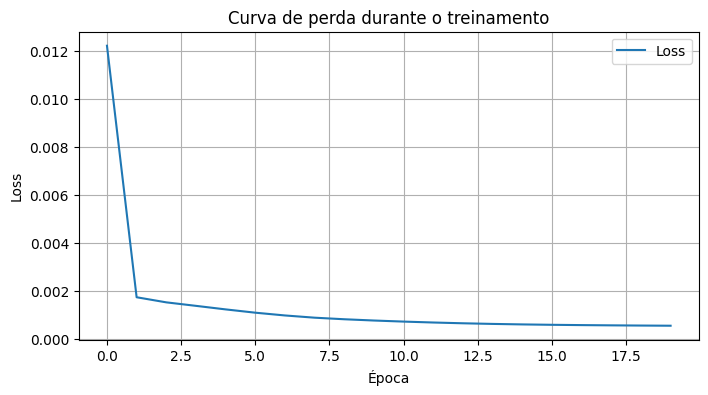

In [41]:
# Curva de perda
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Loss')
plt.title('Curva de perda durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [42]:
# Salvamento do modelo e scalers
model.save('modelo_lstm.h5')
import joblib
joblib.dump(scaler, 'scaler_full.pkl')
joblib.dump(close_scaler, 'scaler_close.pkl')

['scaler_close.pkl']

In [43]:
# Previsão
predictions = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


In [44]:
# Inversão da Normalização (Close)
predicted_prices = close_scaler.inverse_transform(predictions)
real_prices = close_scaler.inverse_transform(y_test.reshape(-1, 1))


In [45]:
# Avaliação completa (todo teste)
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Avaliação completa (todo teste)
real_flat = real_prices.flatten()
pred_flat = predicted_prices.flatten()

mae_total = mean_absolute_error(real_flat, pred_flat)
rmse_total = np.sqrt(mean_squared_error(real_flat, pred_flat))
mape_total = np.mean(np.abs((real_flat - pred_flat) / real_flat)) * 100
smape_total = smape(real_flat, pred_flat)

real_dir = np.sign(np.diff(real_flat))
pred_dir = np.sign(np.diff(pred_flat))
acc_direcional_total = np.mean(real_dir == pred_dir) * 100

print(f"MAE (total): {mae_total:.4f}")
print(f"RMSE (total): {rmse_total:.4f}")
print(f"MAPE (total): {mape_total:.2f}%")
print(f"SMAPE (total): {smape_total:.2f}%")
print(f"Acurácia Direcional (total): {acc_direcional_total:.2f}%")


MAE (total): 1.3094
RMSE (total): 1.8006
MAPE (total): 1.39%
SMAPE (total): 1.39%
Acurácia Direcional (total): 51.04%


In [46]:
print("\n--- Interpretação dos Resultados ---")
print(f"O MAE de {mae_total:.4f} indica que, em média, o modelo erra o preço em aproximadamente {mae_total:.4f} unidades monetárias.")
print(f"O RMSE de {rmse_total:.4f} penaliza mais os erros maiores, mostrando que os desvios maiores são relativamente {'baixos' if rmse_total < 1 else 'altos'}.")
print(f"O MAPE de {mape_total:.2f}% mostra que o erro percentual médio é {mape_total:.2f}%, indicando que o modelo é { 'preciso' if mape_total < 10 else 'pouco preciso' } para previsões relativas.")
print(f"O SMAPE de {smape_total:.2f}% confirma a simetria no erro percentual, útil para dados com valores próximos a zero.")
print(f"A acurácia direcional de {acc_direcional_total:.2f}% indica que o modelo acertou a direção do movimento do preço em cerca de {acc_direcional_total:.2f}% dos casos, o que é {'acima do acaso' if acc_direcional_total > 50 else 'pouco confiável'}.\n")


--- Interpretação dos Resultados ---
O MAE de 1.3094 indica que, em média, o modelo erra o preço em aproximadamente 1.3094 unidades monetárias.
O RMSE de 1.8006 penaliza mais os erros maiores, mostrando que os desvios maiores são relativamente altos.
O MAPE de 1.39% mostra que o erro percentual médio é 1.39%, indicando que o modelo é preciso para previsões relativas.
O SMAPE de 1.39% confirma a simetria no erro percentual, útil para dados com valores próximos a zero.
A acurácia direcional de 51.04% indica que o modelo acertou a direção do movimento do preço em cerca de 51.04% dos casos, o que é acima do acaso.



In [49]:
# Avaliação Final (últimos 7 dias)
real_7 = real_prices[-7:].flatten()
pred_7 = predicted_prices[-7:].flatten()

mae_7 = mean_absolute_error(real_7, pred_7)
rmse_7 = np.sqrt(mean_squared_error(real_7, pred_7))
mape_7 = np.mean(np.abs((real_7 - pred_7) / real_7)) * 100
smape_7 = smape(real_7, pred_7)

real_dir = np.sign(np.diff(real_7))
pred_dir = np.sign(np.diff(pred_7))
acc_direcional = np.mean(real_dir == pred_dir) * 100

print(f"MAE (últimos 7 dias): {mae_7:.4f}")
print(f"RMSE (últimos 7 dias): {rmse_7:.4f}")
print(f"MAPE (últimos 7 dias): {mape_7:.2f}%")
print(f"SMAPE (últimos 7 dias): {smape_7:.2f}%")
print(f"Acurácia Direcional (últimos 7 dias): {acc_direcional:.2f}%")

MAE (últimos 7 dias): 0.8527
RMSE (últimos 7 dias): 1.1890
MAPE (últimos 7 dias): 0.76%
SMAPE (últimos 7 dias): 0.76%
Acurácia Direcional (últimos 7 dias): 50.00%


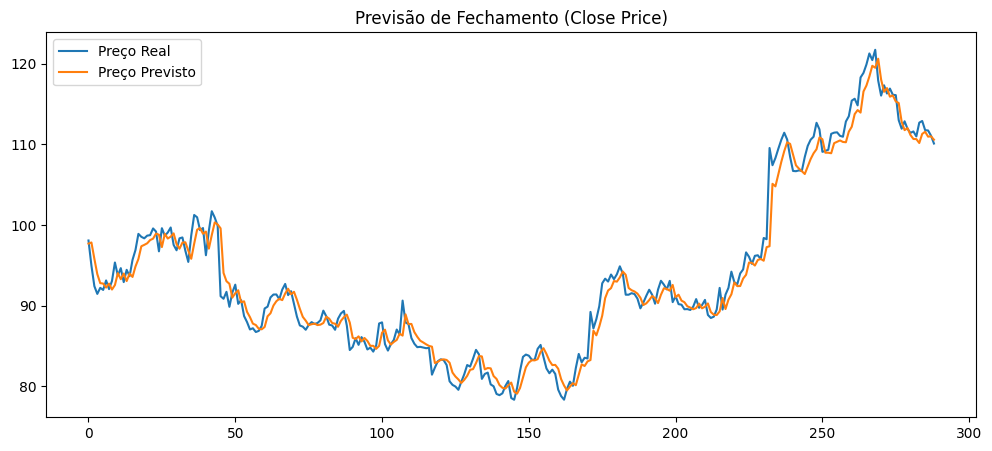

In [50]:
# Visualização Final: Comparação entre Preços Reais e Previstos
plt.figure(figsize=(12, 5))
plt.plot(real_prices, label='Preço Real')
plt.plot(predicted_prices, label='Preço Previsto')
plt.title('Previsão de Fechamento (Close Price)')
plt.legend()
plt.show()